In [1]:
## This script was adapted from the following paper/tutorial: 

#de Gee JW, Tsetsos T, McCormick DA, McGinley MJ & Donner TH. 2018. Phasic arousal optimizes decision computations in mice and humans. bioRxiv. (https://www.biorxiv.org/content/early/2018/10/19/447656).

#https://hddm.readthedocs.io/en/latest/tutorial_gonogo_chisquare.html
    
#The scripts were published as free to use. They have been amended to fit to the emotional interference go/no-go paradigm.

#Script makes use of docker image w/ Python 3

# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from joblib import Parallel, delayed

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
def get_choice(row):

    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0

def simulate_data(a, v, t, z, dc, sv=0, sz=0, st=0, condition=0, nr_trials1=1000, nr_trials2=1000):

    """
    Simulates stim-coded data.
    """

    parameters1 = {'a':a, 'v':v+dc, 't':t, 'z':z, 'sv':sv, 'sz': sz, 'st': st}
    parameters2 = {'a':a, 'v':v-dc, 't':t, 'z':1-z, 'sv':sv, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=1, subj_noise=0)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=1, subj_noise=0)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])

    return df_sim

def fit_subject(data, quantiles):

    """
    Simulates stim-coded data.
    """

    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, stim_col='stimulus', split_param='v', drift_criterion=True, bias=True, p_outlier=0,
                            depends_on={'v':'condition', 'a':'condition', 't':'condition', 'z':'condition', 'dc':'condition', })
    m.optimize('gsquare', quantiles=quantiles, n_runs=8)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

def summary_plot(df_group, df_sim_group=None, quantiles=[0, 0.1, 0.3, 0.5, 0.7, 0.9,], xlim=None):

    """
    Generates a
    """

    nr_subjects = len(np.unique(df_group['subj_idx']))

    fig = plt.figure(figsize=(10,nr_subjects*2))
    plt_nr = 1
    for s in np.unique(df_group['subj_idx']):
        df = df_group.copy().loc[(df_group['subj_idx']==s),:]
        df_sim = df_sim_group.copy().loc[(df_sim_group['subj_idx']==s),:]
        df['rt_acc'] = df['rt'].copy()
        df.loc[df['correct']==0, 'rt_acc'] = df.loc[df['correct']==0, 'rt_acc'] * -1
        df['rt_resp'] = df['rt'].copy()
        df.loc[df['response']==0, 'rt_resp'] = df.loc[df['response']==0, 'rt_resp'] * -1
        df_sim['rt_acc'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['correct']==0, 'rt_acc'] = df_sim.loc[df_sim['correct']==0, 'rt_acc'] * -1
        df_sim['rt_resp'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['response']==0, 'rt_resp'] = df_sim.loc[df_sim['response']==0, 'rt_resp'] * -1
        max_rt = np.percentile(df_sim.loc[~np.isnan(df_sim['rt']), 'rt'], 99)
        bins = np.linspace(-max_rt,max_rt,30)
        # rt distributions correct vs error:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        N, bins, patches = ax.hist(df.loc[:, 'rt_acc'], bins=bins,
                                   density=True, color='green', alpha=0.5)


        for bin_size, bin, patch in zip(N, bins, patches):
            if bin < 0:
                plt.setp(patch, 'facecolor', 'r')
        if df_sim is not None:
            ax.hist(df_sim.loc[:, 'rt_acc'], bins=bins, density=True,
                    histtype='step', color='k', alpha=1, label=None)
        ax.set_title('P(correct)={}'.format(round(df.loc[:, 'correct'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1

        # condition accuracy plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0, 1.25)
        ax.set_title('Conditional accuracy')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(correct)')
        plt_nr += 1

        # rt distributions response 1 vs 0:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        if np.isnan(df['rt']).sum() > 0:
            # some initial computations
            bar_width = 1
            fraction_yes = df['response'].mean()
            fraction_yes_sim = df_sim['response'].mean()
            no_height = (1 - fraction_yes) / bar_width
            no_height_sim = (1 - fraction_yes_sim) / bar_width

            hist, edges = np.histogram(df.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist = hist * fraction_yes
            hist_sim, edges_sim = np.histogram(df_sim.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist_sim = hist_sim * fraction_yes_sim

            # Add histogram from go choices
            # ground truth
            ax.bar(edges[:-1], hist, width=np.diff(edges)[0], align='edge',
                   color='magenta', alpha=0.5, linewidth=0,)
            # simulations
            ax.step(edges_sim[:-1] + np.diff(edges)[0], hist_sim, color='black', lw=1)

            # Add bar for the no-go choices (on the negative rt scale)
            # This just illustrates the probability of no-go choices

            # ground truth
            ax.bar(x=-1.5, height=no_height, width=bar_width, alpha=0.5, color='cyan', align='center')

            # simulations
            ax.hlines(y=no_height_sim, xmin=-2, xmax=-1, lw=0.5, colors='black',)
            ax.vlines(x=-2, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
            ax.vlines(x=-1, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
        else:
            N, bins, patches = ax.hist(df.loc[:, 'rt_resp'], bins=bins,
                                   density=True, color='magenta', alpha=0.5)
            for bin_size, bin, patch in zip(N, bins, patches):
                if bin < 0:
                    plt.setp(patch, 'facecolor', 'cyan')
            ax.hist(df_sim.loc[:, 'rt_resp'], bins=bins, density=True,
                    histtype='step', color='k', alpha=1, label=None)

        ax.set_title('P(bias)={}'.format(round(df.loc[:, 'response'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1

        # condition response plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0,1.25)
        ax.set_title('Conditional response')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(bias)')
        plt_nr += 1

    sns.despine(offset=3, trim=True)
    plt.tight_layout()

    return fig

In [103]:
# settings
go_nogo = True # should we put all RTs for one choice alternative to NaN (go-no data)?
n_subjects = 27
trials_per_level = 4320

# parameters:
params0 = {'cond':0, 'v':0.5, 'a':2.0, 't':0.3, 'z':0.5, 'dc':-0.2, 'sz':0, 'st':0, 'sv':0}
params1 = {'cond':1, 'v':0.5, 'a':2.0, 't':0.3, 'z':0.5, 'dc':0.2, 'sz':0, 'st':0, 'sv':0}

# simulate:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'],
                        t=params0['t'], sv=params0['sv'], st=params0['st'], sz=params0['sz'],
                        condition=params0['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'],
                        t=params1['t'], sv=params1['sv'], st=params1['st'], sz=params1['sz'],
                        condition=params1['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = i
    dfs.append(df)

# combine in one dataframe:
df_emp = pd.concat(dfs)
if go_nogo:
    df_emp.loc[df_emp["response"]==0, 'rt'] = np.NaN

In [57]:
df_emp

,Unnamed: 0,rt,response,subj_idx,condition,correct,stimulus
0,4161,NaN,0.0,28.0,1,0.000000,1
1,4162,0.264167,1.0,28.0,1,1.000000,1
2,4163,0.237097,1.0,28.0,1,1.000000,1
3,4164,0.278674,1.0,28.0,1,1.000000,1
4,4165,0.294238,1.0,28.0,1,1.000000,1
...,...,...,...,...,...,...,...
4395,8556,NaN,NaN,NaN,1,1388.403952,1
4396,8557,NaN,NaN,NaN,1,1393.102182,1
4397,8558,NaN,NaN,NaN,1,1395.435225,1
4398,8559,NaN,NaN,NaN,1,1400.008861,1


In [107]:
df_emp = pd.read_csv(r'ScrambleDDM_Pre_2.csv')
df_emp

,Unnamed: 0,rt,response,subj_idx,condition,correct,stimulus
0,1,NaN,0,13,0,0,1
1,2,0.253442,1,13,0,1,1
2,3,0.201615,1,13,0,1,1
3,4,0.302657,1,13,0,0,0
4,5,0.307757,1,13,0,1,1
...,...,...,...,...,...,...,...
4155,4156,0.302697,1,27,0,1,1
4156,4157,NaN,0,27,0,1,0
4157,4158,0.303306,1,27,0,1,1
4158,4159,0.314723,1,27,0,1,1


In [109]:
# fit chi-square:
quantiles = [.1, .3, .5, .7, .9]
params_fitted = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data[1], quantiles)
                                                      for data in df_emp.groupby('subj_idx')))
print(params_fitted)

        a(0)       v(0)      t(0)  z_trans(0)      z(0)      dc(0)  \
1   2.114905  -0.654740  0.001957   -2.885101  0.052895   8.411282   
2   0.775552   3.088534  0.207513   -0.528046  0.370973   1.348971   
3   0.605030   2.959007  0.232712    0.001855  0.500464   1.357292   
4   0.868872   1.405913  0.112756   -0.476834  0.383000   1.985334   
5   0.610980   4.247786  0.221743    0.251803  0.562620   0.356347   
6   0.735595   3.994831  0.223458   -0.407387  0.399539   1.509533   
7   0.759013   4.327661  0.196488   -1.027947  0.263482   2.324868   
8   0.734095   1.279476  0.172676   -1.455764  0.189116   2.301640   
9   0.695892   1.594502  0.205191   -0.336247  0.416721   1.683015   
10  0.714847   1.735478  0.201717   -0.770445  0.316383   1.808670   
11  2.719273  -0.276074  0.012913   -3.490108  0.029595  10.260431   
12  0.629803   3.739278  0.226601    0.185243  0.546179  -0.272117   
13  0.681382   3.531104  0.220113   -1.122294  0.245586   2.362777   
14  0.888289   4.770

In [36]:
params_fitted.drop(['bic', 'likelihood', 'penalty', 'z_trans(1)'], axis=1, inplace=True)
print(params_fitted)

        a(1)      v(1)      t(1)      z(1)     dc(1)
1   0.608736  4.731784  0.238040  0.633355 -0.680826
2   0.846811  2.588559  0.181698  0.314526  1.988047
3   0.706960  2.596542  0.218448  0.441164  1.619281
4   2.271274 -0.471573  0.050195  0.039987  9.124231
5   0.813955  4.342158  0.199927  0.349300  1.885638
6   1.830980  6.081381  0.140879  0.067150  4.906136
7   0.707459  3.134116  0.205000  0.233922  1.649761
8   2.558291 -0.356534  0.001565  0.018291  8.402260
9   0.749627  2.564389  0.198415  0.306631  2.164298
10  1.386673  5.600173  0.189353  0.023175  4.421296
11  0.953673  1.493906  0.130072  0.314108  2.369326
12  0.755154  3.698343  0.215105  0.439284  1.636590
13  0.640274  3.806322  0.213705  0.432811  0.716740
14  0.798005  3.954764  0.185503  0.331755  1.540400
15  0.735068  4.197258  0.205477  0.351369  2.222252
16  0.877612  1.706221  0.141711  0.314444  2.307877
17  0.715778  2.957462  0.202486  0.393847  1.246427
18  0.783738  1.932551  0.164906  0.347508  2.

In [106]:
params_fitted.to_csv('pre_2.csv', index=False)

In [37]:
# simulate data based on fitted params:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(a=params_fitted.loc[i,'a(0)'], v=params_fitted.loc[i,'v(0)'],
                        t=params_fitted.loc[i,'t(0)'], z=params_fitted.loc[i,'z(0)'],
                        dc=params_fitted.loc[i,'dc(0)'], condition=0, nr_trials1=trials_per_level,
                        nr_trials2=trials_per_level)
    df1 = simulate_data(a=params_fitted.loc[i,'a(1)'], v=params_fitted.loc[i,'v(1)'],
                        t=params_fitted.loc[i,'t(1)'], z=params_fitted.loc[i,'z(1)'],
                        dc=params_fitted.loc[i,'dc(1)'], condition=1, nr_trials1=trials_per_level,
                        nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = i
    dfs.append(df)
df_sim = pd.concat(dfs)
if go_nogo:
    df_sim.loc[df_sim["response"]==0, 'rt'] = np.NaN

KeyError: 0

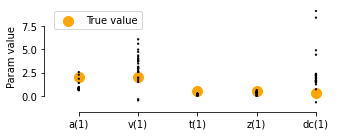

In [38]:
# Plot true vs recovered parameters:
x = np.arange(5) * 2
y0 = np.array([params0['a'], params0['v'], params0['t'], params0['z'], params0['dc']])
y1 = np.array([params1['a'], params1['v'], params1['t'], params1['z'], params1['dc']])
fig = plt.figure(figsize=(5,2))
ax = fig.add_subplot(111)
ax.scatter(x, y0, marker="o", s=100, color='orange', label='True value')
ax.scatter(x+1, y1, marker="o", s=100, color='orange',)
sns.stripplot(data=params_fitted, jitter=False, size=2, edgecolor='black', linewidth=0.25, alpha=1, palette=['black', 'black'], ax=ax)
plt.ylabel('Param value')
plt.legend()
sns.despine(offset=5, trim=True,)
plt.tight_layout()
plt.show()

In [14]:
# Plot data with model fit on top:
for c in np.unique(df_emp['condition']):
    print('CONDITION {}'.format(c))
    summary_plot(df_group=df_emp.loc[(df_emp['condition']==c),:],
                 df_sim_group=df_sim.loc[(df_emp['condition']==c),:])
    plt.show()

CONDITION 1


NameError: name 'df_sim' is not defined

In [ ]:
CONDITION 1